In [1]:
import cartopy.feature as cfeature
from matplotlib import colors
from PIL import Image
import pandas as pd
import seaborn as sns
from scipy.stats import pearsonr
from matplotlib.patheffects import withStroke
from matplotlib.image import imread
from osgeo import gdal
from tqdm import tqdm
import rasterio as rio
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from tqdm import tqdm
from matplotlib.colors import ListedColormap
import os

In [3]:
def raster_pixel_proportions(raster_path, bins, output_path):
    # 打开栅格数据文件
    dataset = gdal.Open(raster_path)

    # 获取栅格数据的宽度和高度
    cols = dataset.RasterXSize
    rows = dataset.RasterYSize

    # 获取栅格数据的地理参考信息
    transform = dataset.GetGeoTransform()

    # 获取栅格数据的第一个波段
    band = dataset.GetRasterBand(1)

    # 将栅格数据读取为numpy数组
    data = band.ReadAsArray(0, 0, cols, rows)

    # 关闭栅格数据文件
    dataset = None
    data_no_zero = np.where(data == 0, np.nan, data)
    data_filtered = data_no_zero[~np.isnan(data_no_zero)]
    # 使用numpy的digitize方法将栅格数据分到不同的区间
    digitized = np.digitize(data_filtered, bins, right=False)

    # 统计每个区间中的像素数量
    pixel_counts = np.bincount(digitized.flatten())[1:]

    # 计算每个区间中的像素比例
    total_pixels = np.sum(pixel_counts)
    pixel_proportions = pixel_counts / total_pixels

    # 将结果保存到csv文件
    bin_labels = ["High negative correlation", "moderate negative correlation", "weak negative correlation",
                  "weak positive correlation", "moderate positive correlation", "high positive correlation"]
    df = pd.DataFrame({raster_path: pixel_proportions}).T
    df.to_csv(output_path, mode='a', header=None)


def combine_images_vertically(images, output_path):
    """
    将多张图片按照原有长宽比例拉伸后拼接在一起，并保存为一张图片。

    参数：
    images: 包含多张图片地址的列表。
    output_path: 拼接结果图片的保存地址。

    返回值：
    无返回值。
    """
    # 读取所有图片并获取宽度和高度
    pil_images = [Image.open(image) for image in images]
    widths, heights = zip(*(image.size for image in pil_images))

    # 计算拼接后图片的总宽度和总高度
    max_width = max(widths)
    total_height = sum(heights)

    # 创建一个新的空白图片，用于存储拼接结果
    combined_image = Image.new('RGB', (max_width, total_height))

    y_offset = 0
    # 将每张图片按原有长宽比例拉伸并拼接到新图片上
    for pil_image, height in zip(pil_images, heights):
        width = pil_image.width
        resized_image = pil_image.resize((max_width, height), Image.ANTIALIAS)
        combined_image.paste(resized_image, (0, y_offset))
        y_offset += height

    # 保存拼接结果图片
    combined_image.save(output_path)


def combine_images_vertically_limit(images, output_path, limit):
    """
    将多张PNG图像纵向组合为一张图像，并保存为PNG格式。

    参数：
    images: 包含多张PNG图像的列表。
    output_path: 组合后图像的保存路径。

    返回值：
    无返回值。
    """
    # 读取所有PNG图像
    pil_images = [Image.open(image) for image in images]

    # 获取每张图像的尺寸
    width, height = pil_images[0].size

    # 计算每列最多可以容纳几张图像
    max_images_per_column = limit

    # 计算组合后图像的总行数和总列数
    num_images = len(pil_images)
    num_rows = (num_images + max_images_per_column - 1) // max_images_per_column
    num_columns = min(num_images, max_images_per_column)

    # 创建一个新的空白图像，用于存储组合后的图像
    combined_image = Image.new('RGB', (num_columns * width, num_rows * height))

    # 将所有图像按顺序拼接到新图像上
    for i in range(num_rows):
        for j in range(num_columns):
            index = i * num_columns + j
            if index < num_images:
                pil_image = pil_images[index]

            else:
                pil_image = Image.new('RGB', (width, height), color='white')

            combined_image.paste(pil_image, (j * width, i * height))

    # 保存组合后的图像
    combined_image.save(output_path)

# 叶绿素浓度年度和月度的值

def plot_raster_images_continuous(filenames, titles, area, topics, cliprange, fontsize=20):
    """
    绘制多张栅格图像，图像按照给定的名称列表横向排列，共用一个统一的colorbar，并且
    色带的范围和图像渲染的范围均为图像像素值范围的1%~99%。绘制的图像包含经纬度边框、
    海岸线和国界线等地图特征，并且图像显示的范围从栅格数据的元数据中读取。

    :param filenames: 包含栅格数据文件名的列表
    :type filenames: list
    :param titles: 包含每张图像名称的列表
    :type titles: list
    """
    # 读取栅格数据和元数据
    data = []
    bounds = []
    tif_path = './0_cartopy_data/NE1_50M_SR_W.tif'
    for filename in filenames:
        with rio.open(filename) as src:
            data.append(src.read(1, masked=True))
            transform = src.transform
            height, width = src.height, src.width
            left, bottom = transform * (0, height)
            right, top = transform * (width, 0)
            bounds.append((left, right, bottom, top))

    vmin_max_data = np.where(np.array(data).flatten() == 0, np.nan, np.array(data).flatten())
    # 获取像素值范围的1%~99%
    vmin = np.nanpercentile(vmin_max_data, cliprange[0])
    vmax = np.nanpercentile(vmin_max_data, cliprange[1])

    # 创建图例
    fig, ax = plt.subplots(nrows=1, ncols=len(data), figsize=(25, 2),
                           subplot_kw=dict(projection=ccrs.PlateCarree()))

    for i, d in enumerate(data):
        colors_list = ['#2b83ba', "#abdda4", "#ffffbf", "#fdae61", "#d7191c"]
        self_defined_cmap = colors.LinearSegmentedColormap.from_list('custom_cmap', colors_list)

        ax[i].imshow(
            imread(tif_path),
            origin='upper',
            transform=ccrs.PlateCarree(),
            extent=[-180, 180, -90, 90]
        )
        im = ax[i].imshow(d, vmin=vmin, vmax=vmax, cmap=self_defined_cmap, extent=bounds[i],transform=ccrs.PlateCarree())
        ax[i].set_title(titles[i], fontsize=fontsize)
        ax[i].coastlines()
        ax[i].add_feature(cfeature.LAND.with_scale('110m'), edgecolor='black')
        rivers = cfeature.NaturalEarthFeature('physical', 'rivers_lake_centerlines', '110m',
                                              edgecolor='blue',
                                              facecolor='none')

        # ax[i].add_feature(rivers)
        ax[i].set_extent(bounds[i])

        # 添加经纬度边框
        xlocs = np.linspace(bounds[i][0], bounds[i][1], 2)
        ylocs = np.linspace(bounds[i][2], bounds[i][3], 3)
        ax[i].set_xticks(xlocs, crs=ccrs.PlateCarree())
        ax[i].set_yticks(ylocs, crs=ccrs.PlateCarree())
        ax[i].xaxis.set_ticklabels(['{:.1f}°E'.format(x) for x in ax[i].get_xticks()], fontsize=fontsize)
        ax[i].yaxis.set_ticklabels(['{:.1f}°N'.format(y) for y in ax[i].get_yticks()], fontsize=fontsize)
        ax[i].gridlines(linestyle='--')
        ax[i].tick_params(axis='x', which='both', pad=10)

    # 添加统一的colorbar

    plt.subplots_adjust(wspace=1, hspace=0)
    cbar = fig.colorbar(im, ax=ax, shrink=1, location='right')
    cbar.ax.tick_params(labelsize=fontsize)  # 调整刻度的大小
    cbar.ax.set_ylabel(topics, fontsize=fontsize)
    plt.savefig('./result/' + topics + '_fig_' + area + '.png',bbox_inches='tight')
    # 显示图像
    #
    plt.show()

def plot_raster_images_segmentation(filenames, titles, area, topics, cliprange, colorbounds, colorstypes, fontsize=20):
    """
    绘制多张栅格图像，图像按照给定的名称列表横向排列，共用一个统一的colorbar，并且
    色带的范围和图像渲染的范围均为图像像素值范围的1%~99%。绘制的图像包含经纬度边框、
    海岸线和国界线等地图特征，并且图像显示的范围从栅格数据的元数据中读取。

    :param filenames: 包含栅格数据文件名的列表
    :type filenames: list
    :param titles: 包含每张图像名称的列表
    :type titles: list
    """
    # 读取栅格数据和元数据
    data = []
    bounds = []
    tif_path = './0_cartopy_data/NE1_50M_SR_W.tif'
    for filename in filenames:
        with rio.open(filename) as src:
            data.append(src.read(1, masked=True))
            transform = src.transform
            height, width = src.height, src.width
            left, bottom = transform * (0, height)
            right, top = transform * (width, 0)
            bounds.append((left, right, bottom, top))

    vmin_max_data = np.where(np.array(data).flatten() == 0, np.nan, np.array(data).flatten())
    # 获取像素值范围的1%~99%
    vmin = np.nanpercentile(vmin_max_data, cliprange[0])
    vmax = np.nanpercentile(vmin_max_data, cliprange[1])

    # 创建图例
    fig, ax = plt.subplots(nrows=1, ncols=len(data), figsize=(25, 2),
                           subplot_kw=dict(projection=ccrs.PlateCarree()))
    
    for i, d in enumerate(data):
        cmap = ListedColormap(colorstypes)
        norm = plt.Normalize(colorbounds[0], colorbounds[-1])

        ax[i].imshow(
            imread(tif_path),
            origin='upper',
            transform=ccrs.PlateCarree(),
            extent=[-180, 180, -90, 90]
        )
        im = ax[i].imshow(d, norm=norm, cmap=cmap, extent=bounds[i],
                          transform=ccrs.PlateCarree())
        ax[i].set_title(titles[i], fontsize=fontsize)
        ax[i].coastlines()
        ax[i].add_feature(cfeature.LAND.with_scale('110m'), edgecolor='black')
        rivers = cfeature.NaturalEarthFeature('physical', 'rivers_lake_centerlines', '110m',
                                              edgecolor='blue',
                                              facecolor='none')

        # ax[i].add_feature(rivers)
        ax[i].set_extent(bounds[i])

        # 添加经纬度边框
        xlocs = np.linspace(bounds[i][0], bounds[i][1], 2)
        ylocs = np.linspace(bounds[i][2], bounds[i][3], 3)
        ax[i].set_xticks(xlocs, crs=ccrs.PlateCarree())
        ax[i].set_yticks(ylocs, crs=ccrs.PlateCarree())
        ax[i].xaxis.set_ticklabels(['{:.1f}°E'.format(x) for x in ax[i].get_xticks()], fontsize=fontsize)
        ax[i].yaxis.set_ticklabels(['{:.1f}°N'.format(y) for y in ax[i].get_yticks()], fontsize=fontsize)
        ax[i].gridlines(linestyle='--')
        ax[i].tick_params(axis='x', which='both', pad=10)

    # 添加统一的colorbar
    plt.subplots_adjust(wspace=1, hspace=0.1)
    plt.subplots_adjust(wspace=0.75, hspace=0)
    cbar = fig.colorbar(im, ax=ax, shrink=1, location='right', ticks=colorbounds, boundaries=colorbounds)
    cbar.ax.tick_params(labelsize=fontsize)  #
    cbar.ax.set_ylabel(topics, fontsize=fontsize)
    plt.savefig('./result/' + topics + '_fig_' + area + '.png',bbox_inches='tight')
    # 显示图像

    plt.show()

  0%|          | 0/5 [00:00<?, ?it/s]

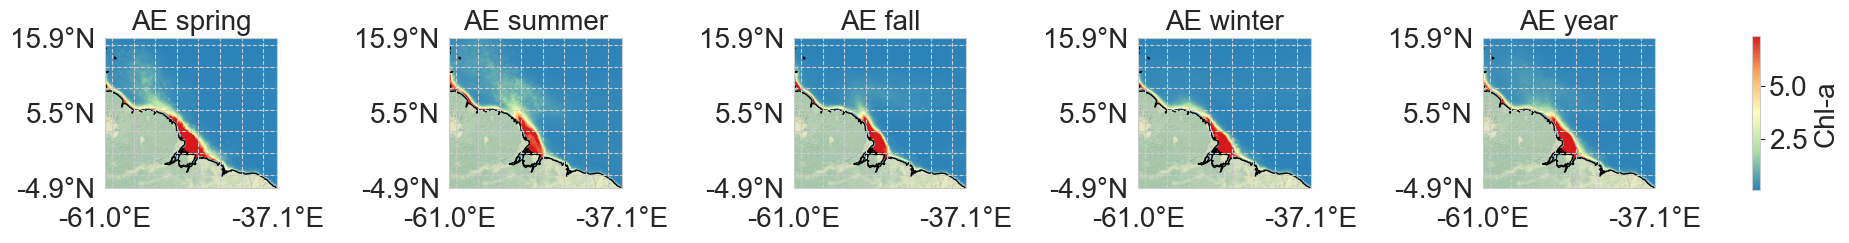

 20%|██        | 1/5 [00:18<01:14, 18.73s/it]

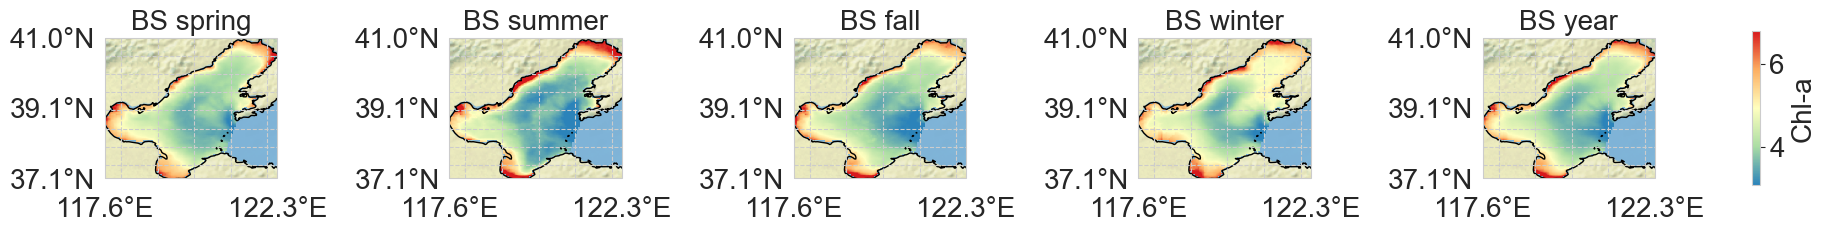

 40%|████      | 2/5 [00:37<00:55, 18.52s/it]

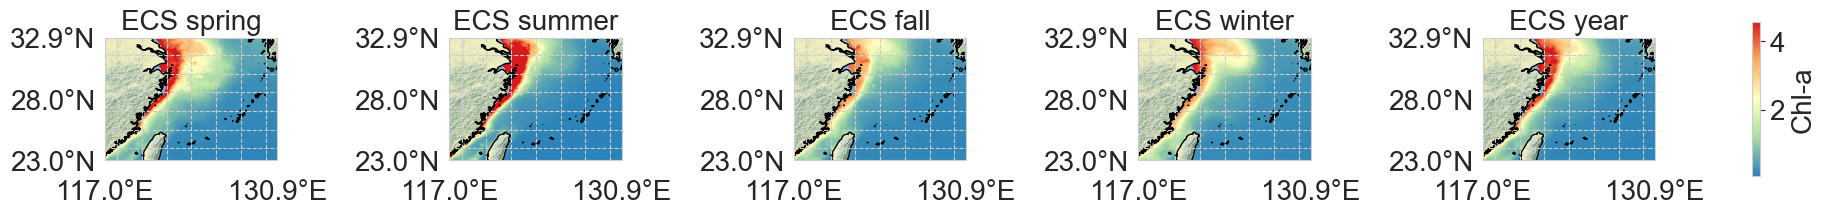

 60%|██████    | 3/5 [00:55<00:37, 18.61s/it]

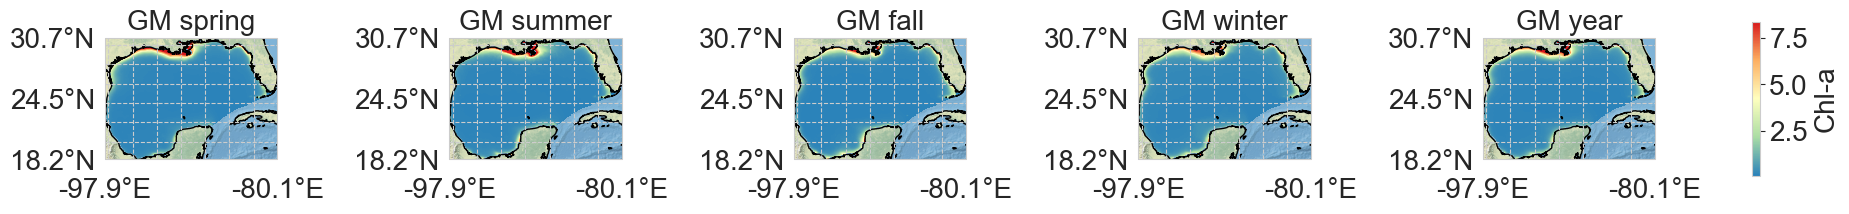

 80%|████████  | 4/5 [01:14<00:18, 18.59s/it]

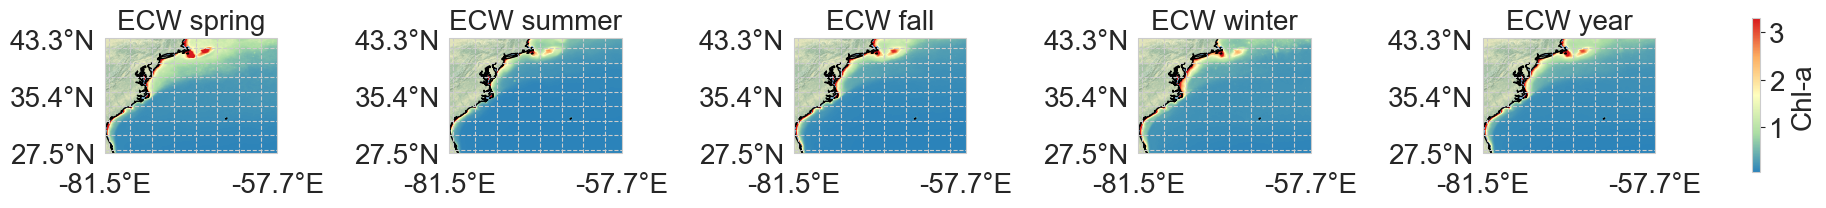

100%|██████████| 5/5 [01:32<00:00, 18.60s/it]
D:\ProgramData\Anaconda3\envs\Python3.7\lib\site-packages\ipykernel_launcher.py:65: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.


In [29]:
# 叶绿素浓度年度和月度的值
def chl_year(file_dir, area,area_simple):
    path1 = file_dir + 'area_spring_chl_avg.tif'
    path2 = file_dir + 'area_summer_chl_avg.tif'
    path3 = file_dir + 'area_fall_chl_avg.tif'
    path4 = file_dir + 'area_winter_chl_avg.tif'
    path5 = file_dir + 'area_year_chl_avg.tif'
    plot_raster_images_continuous([path1, path2, path3, path4, path5],
                                  [area_simple+' spring', area_simple+' summer', area_simple+' fall', area_simple+' winter', area_simple+' year'], area, 'Chl-a', [2, 98])


area_list = ['amazon', 'bohai', 'donghai', 'mexico', 'USEastCoast']
area_list_simple = ['AE', 'BS', 'ECS', 'GM', 'ECW']
for i in tqdm(range(len(area_list))):
    area=area_list[i]
    area_simple=area_list_simple[i]

    chl_year('./06_' + area + '_result_file/', area,area_simple)

combine_images_vertically(['./result/Chl-a_fig_bohai.png', './result/Chl-a_fig_mexico.png',
                           './result/Chl-a_fig_donghai.png', './result/Chl-a_fig_USEastCoast.png',
                           './result/Chl-a_fig_amazon.png'], './Essay_illustration/Chl-a.png')

  0%|          | 0/5 [00:00<?, ?it/s]

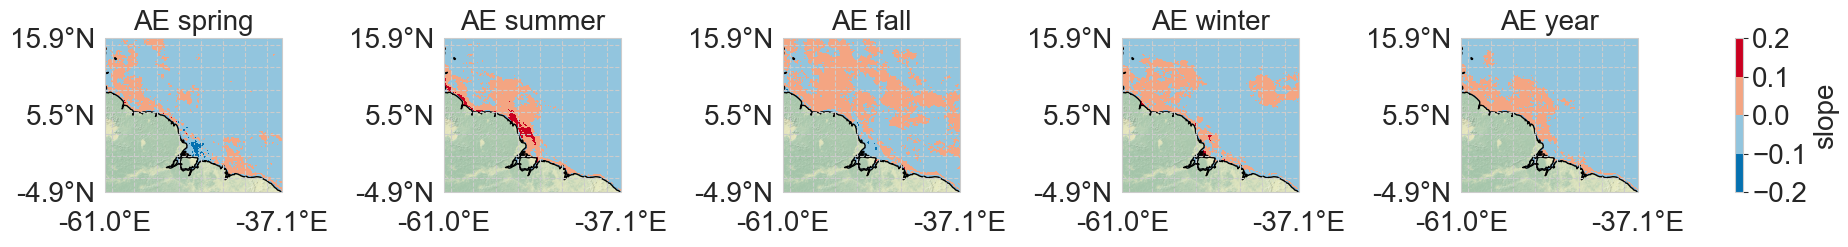

 20%|██        | 1/5 [00:18<01:15, 18.85s/it]

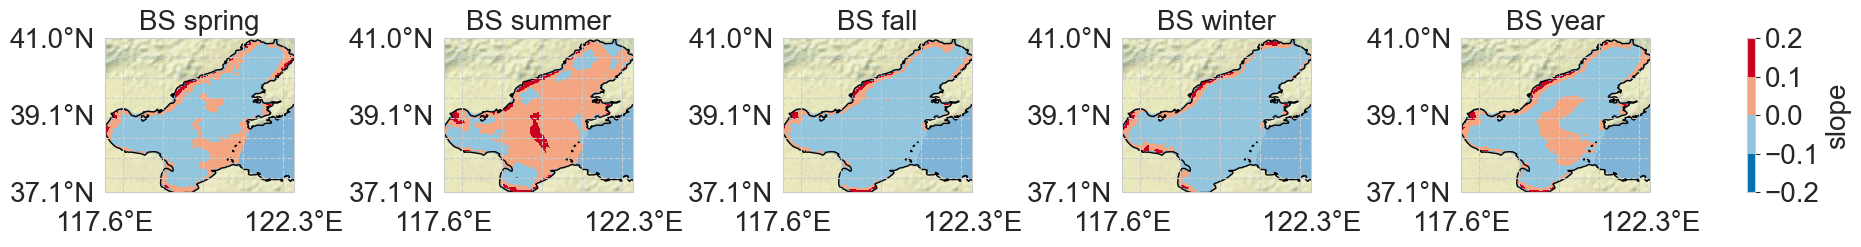

 40%|████      | 2/5 [00:37<00:55, 18.64s/it]

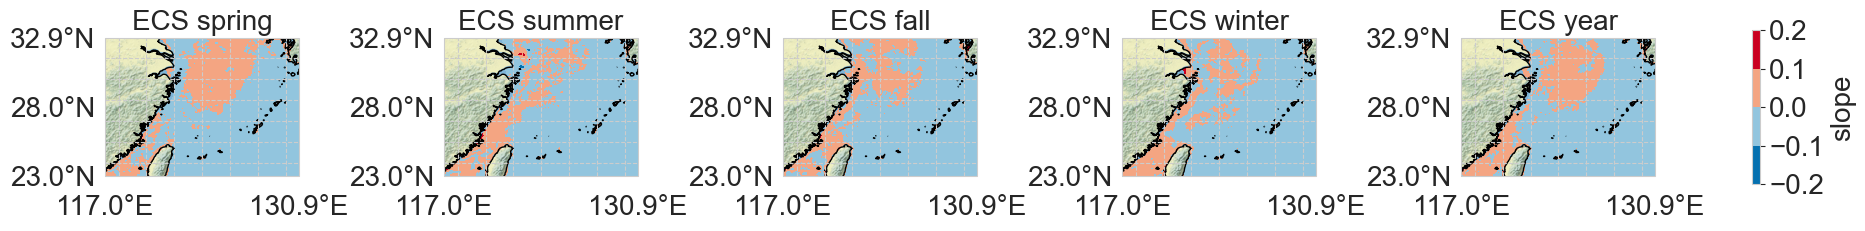

 60%|██████    | 3/5 [00:56<00:37, 18.78s/it]

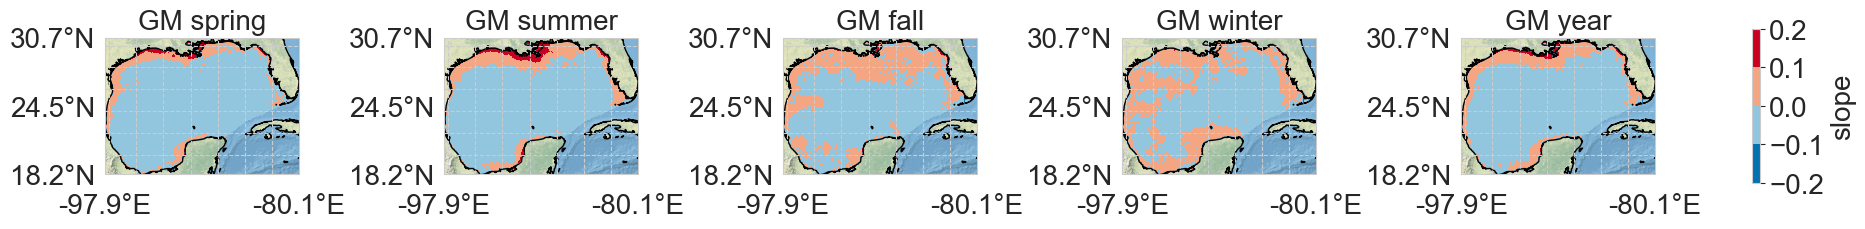

 80%|████████  | 4/5 [01:15<00:18, 18.86s/it]

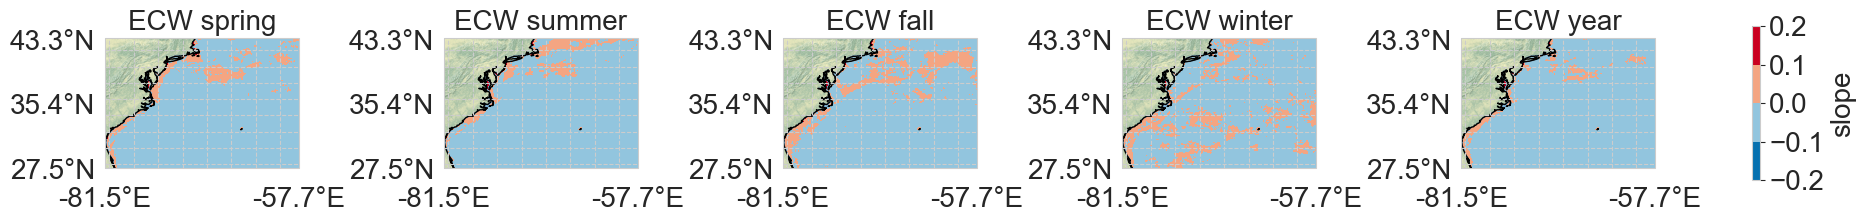

100%|██████████| 5/5 [01:34<00:00, 18.87s/it]
D:\ProgramData\Anaconda3\envs\Python3.7\lib\site-packages\ipykernel_launcher.py:65: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.


In [23]:
def chl_slope_year(file_dir, area,area_simple):
    path1 = file_dir + 'area_spring_slope.tif'
    path2 = file_dir + 'area_summer_slope.tif'
    path3 = file_dir + 'area_fall_slope.tif'
    path4 = file_dir + 'area_winter_slope.tif'
    path5 = file_dir + 'area_yearly_slope.tif'

    colorbounds = [-0.2,-0.1,0,0.1,0.2]
    colortypes = ['#0571b0', "#92c5de",  "#f4a582", "#ca0020"]

    for file in [path1, path2, path3, path4, path5]:
        bins = [-1, 0, 1]
        output_path = './result/slope_output.csv'
        raster_pixel_proportions(file, bins, output_path)


    plot_raster_images_segmentation([path1, path2, path3, path4, path5],
                                    [area_simple+' spring', area_simple+' summer', area_simple+' fall', area_simple+' winter', area_simple+' year'], area, 'slope', [2, 98], colorbounds,colortypes)

    # plot_raster_images_continuous([path1, path2, path3, path4, path5],
    #                               [area_simple+' spring', area_simple+' summer', area_simple+' fall', area_simple+' winter', area_simple+' year'], area, 'slope', [1, 99])

area_list = ['amazon', 'bohai', 'donghai', 'mexico', 'USEastCoast']
area_list_simple = ['AE', 'BS', 'ECS', 'GM', 'ECW']
for i in tqdm(range(len(area_list))):
    area=area_list[i]
    area_simple=area_list_simple[i]

    chl_slope_year('./06_' + area + '_result_file/', area,area_simple)

combine_images_vertically(['./result/slope_fig_bohai.png', './result/slope_fig_mexico.png',
                           './result/slope_fig_donghai.png', './result/slope_fig_USEastCoast.png',
                           './result/slope_fig_amazon.png'], './Essay_illustration/slope-a.png')

  0%|          | 0/5 [00:00<?, ?it/s]

 20%|██        | 1/5 [00:19<01:16, 19.04s/it]

 40%|████      | 2/5 [00:37<00:56, 18.89s/it]

 60%|██████    | 3/5 [00:56<00:37, 18.77s/it]

 80%|████████  | 4/5 [01:15<00:18, 18.91s/it]

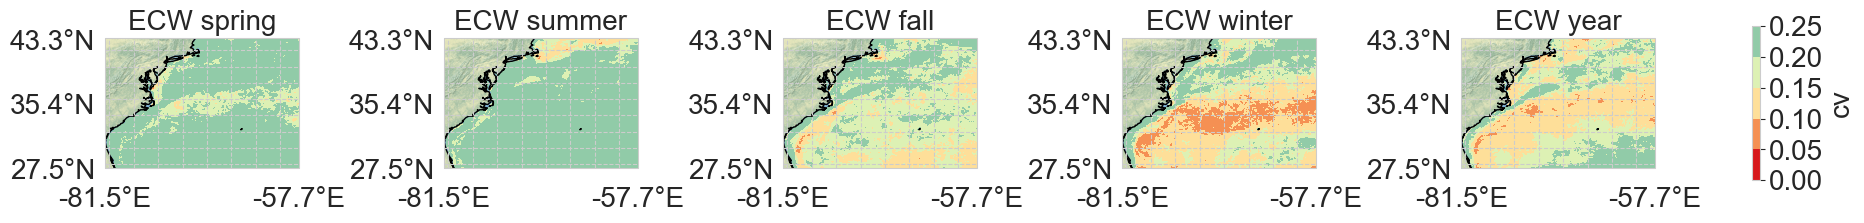

100%|██████████| 5/5 [01:34<00:00, 18.86s/it]
D:\ProgramData\Anaconda3\envs\Python3.7\lib\site-packages\ipykernel_launcher.py:65: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.


In [11]:
def chl_cv_year(file_dir, area,area_simple):
    path1 = file_dir + 'area_spring_cv.tif'
    path2 = file_dir + 'area_summer_cv.tif'
    path3 = file_dir + 'area_fall_cv.tif'
    path4 = file_dir + 'area_winter_cv.tif'
    path5 = file_dir + 'area_yearly_cv.tif'
    colorbounds = [0,0.05,0.10,0.15,0.2,0.25]
    # colortypes = ['#2b83ba', "#abdda4", "#ffffbf", "#fdae61", "#d7191c", "#a6cee3"]
    # colortypes = ['#2b83ba', "#91cba8", "#ddf1b4", "#fedf99", "#f59053","#d7191c"]
    colortypes = ["#d7191c", "#f59053",  "#fedf99", "#ddf1b4","#91cba8"]



    for file in [path1, path2, path3, path4, path5]:
        bins = [0,0.05,0.10,0.15,0.2]
        output_path = './result/cv_output.csv'
        raster_pixel_proportions(file, bins, output_path)

    plot_raster_images_segmentation([path1, path2, path3, path4, path5],
                                    [area_simple+' spring', area_simple+' summer', area_simple+' fall', area_simple+' winter', area_simple+' year'], area, 'cv', [2, 98], colorbounds,
                                    colortypes)

    # plot_raster_images_continuous([path1, path2, path3, path4, path5],
    #                               [area_simple+' spring', area_simple+' summer', area_simple+' fall', area_simple+' winter', area_simple+' year'], area, 'cv', [2, 98])

area_list = ['amazon', 'bohai', 'donghai', 'mexico', 'USEastCoast']
area_list_simple = ['AE', 'BS', 'ECS', 'GM', 'ECW']
for i in tqdm(range(len(area_list))):
    area=area_list[i]
    area_simple=area_list_simple[i]

    chl_cv_year('./06_' + area + '_result_file/', area,area_simple)

combine_images_vertically(['./result/cv_fig_bohai.png', './result/cv_fig_mexico.png',
                           './result/cv_fig_donghai.png', './result/cv_fig_USEastCoast.png',
                           './result/cv_fig_amazon.png'], './Essay_illustration/cv.png')

  0%|          | 0/5 [00:00<?, ?it/s]

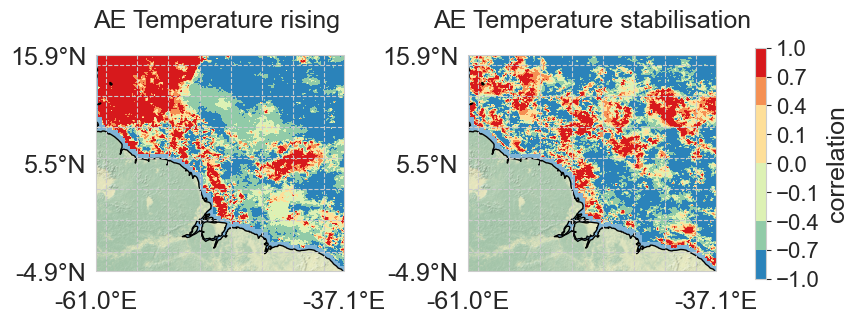

 20%|██        | 1/5 [00:07<00:29,  7.37s/it]

 40%|████      | 2/5 [00:14<00:22,  7.36s/it]

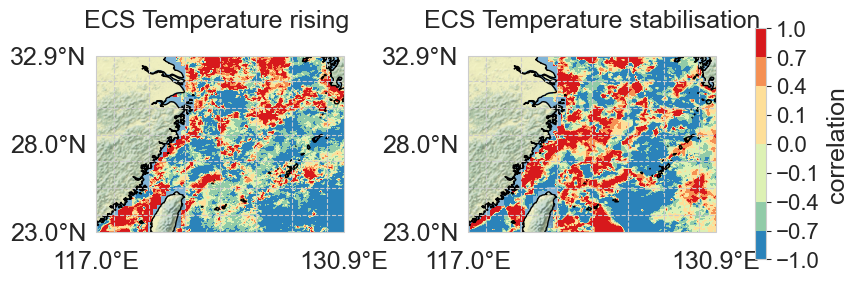

 60%|██████    | 3/5 [00:22<00:14,  7.43s/it]

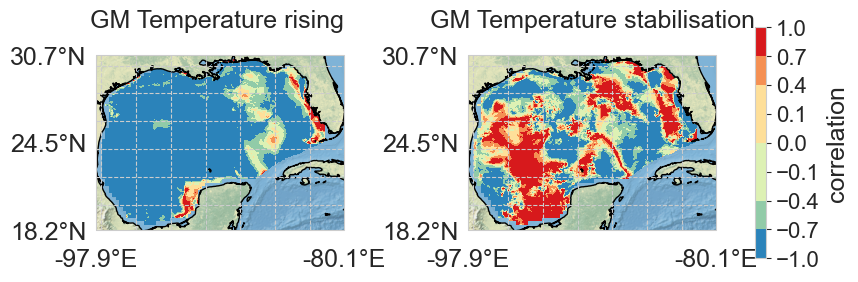

 80%|████████  | 4/5 [00:29<00:07,  7.41s/it]

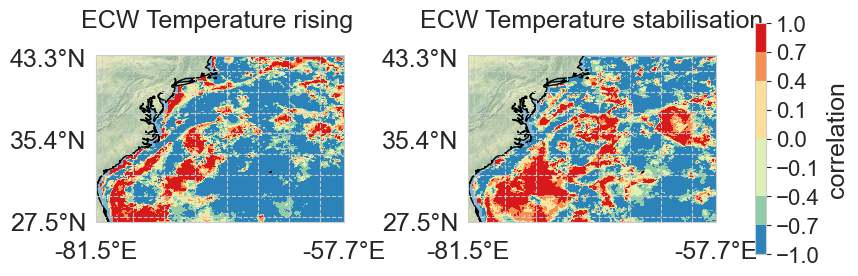

100%|██████████| 5/5 [00:36<00:00,  7.40s/it]


In [8]:
def plot_raster_images_segmentation_corr(filenames, titles, area, topics, cliprange, colorbounds, colorstypes, fontsize=18):
    """
    绘制多张栅格图像，图像按照给定的名称列表横向排列，共用一个统一的colorbar，并且
    色带的范围和图像渲染的范围均为图像像素值范围的1%~99%。绘制的图像包含经纬度边框、
    海岸线和国界线等地图特征，并且图像显示的范围从栅格数据的元数据中读取。

    :param filenames: 包含栅格数据文件名的列表
    :type filenames: list
    :param titles: 包含每张图像名称的列表
    :type titles: list
    """
    # 读取栅格数据和元数据
    data = []
    bounds = []
    tif_path = './0_cartopy_data/NE1_50M_SR_W.tif'
    for filename in filenames:
        with rio.open(filename) as src:
            data.append(src.read(1, masked=True))
            transform = src.transform
            height, width = src.height, src.width
            left, bottom = transform * (0, height)
            right, top = transform * (width, 0)
            bounds.append((left, right, bottom, top))

    vmin_max_data = np.where(np.array(data).flatten() == 0, np.nan, np.array(data).flatten())
    # 获取像素值范围的1%~99%
    vmin = np.nanpercentile(vmin_max_data, cliprange[0])
    vmax = np.nanpercentile(vmin_max_data, cliprange[1])

    # 创建图例
    fig, ax = plt.subplots(nrows=1, ncols=len(data), figsize=(10, 3),
                           subplot_kw=dict(projection=ccrs.PlateCarree()))
    for i, d in enumerate(data):
        cmap = ListedColormap(colorstypes)
        norm = plt.Normalize(colorbounds[0], colorbounds[-1])

        ax[i].imshow(
            imread(tif_path),
            origin='upper',
            transform=ccrs.PlateCarree(),
            extent=[-180, 180, -90, 90]
        )
        im = ax[i].imshow(d, norm=norm, cmap=cmap, extent=bounds[i],
                          transform=ccrs.PlateCarree())
        title=ax[i].set_title(titles[i], fontsize=fontsize,pad=20)

        ax[i].coastlines()
        ax[i].add_feature(cfeature.LAND.with_scale('110m'), edgecolor='black')
        rivers = cfeature.NaturalEarthFeature('physical', 'rivers_lake_centerlines', '110m',
                                              edgecolor='blue',
                                              facecolor='none')

        # ax[i].add_feature(rivers)
        ax[i].set_extent(bounds[i])

        # 添加经纬度边框
        xlocs = np.linspace(bounds[i][0], bounds[i][1], 2)
        ylocs = np.linspace(bounds[i][2], bounds[i][3], 3)
        ax[i].set_xticks(xlocs, crs=ccrs.PlateCarree())
        ax[i].set_yticks(ylocs, crs=ccrs.PlateCarree())
        ax[i].xaxis.set_ticklabels(['{:.1f}°E'.format(x) for x in ax[i].get_xticks()], fontsize=fontsize)
        ax[i].yaxis.set_ticklabels(['{:.1f}°N'.format(y) for y in ax[i].get_yticks()], fontsize=fontsize)
        ax[i].gridlines(linestyle='--')
        ax[i].tick_params(axis='x', which='both', pad=10)

    # 添加统一的colorbar
    plt.subplots_adjust(wspace=0.5, hspace=0)
    cbar = fig.colorbar(im, ax=ax, shrink=1, location='right', ticks=colorbounds, boundaries=colorbounds)
    cbar.ax.tick_params(labelsize=16)  #
    cbar.ax.set_ylabel(topics, fontsize=fontsize)
    plt.savefig('./result/' + topics + '_fig_' + area + '.png',bbox_inches='tight')
    # 显示图像

    plt.show()

def chl_sst_corr(file_dir, area,area_simple):
    files = os.listdir(file_dir)
    tif_files = [file_dir + f for f in files if "Temperature" in f and f.endswith(".tif")]

    for file in tif_files:
        bins = [-1.0, -0.7, -0.4, 0, 0.4, 0.7, 1.0]
        output_path = './result/corr_output.csv'
        raster_pixel_proportions(file, bins, output_path)

    colorbounds = [-1.0, -0.7, -0.4, -0.1, 0, 0.1, 0.4, 0.7, 1.0]
    colortypes = ['#2b83ba', "#91cba8", "#ddf1b4", "#fedf99", "#f59053", "#d7191c"]

    plot_raster_images_segmentation_corr(tif_files,[area_simple+' Temperature rising ',area_simple+' Temperature stabilisation'] , area, 'correlation', [1, 99], colorbounds, colortypes)

area_list = ['amazon', 'bohai', 'donghai', 'mexico', 'USEastCoast']
area_list_simple = ['AE', 'BS', 'ECS', 'GM', 'ECW']

for i in tqdm(range(len(area_list))):
    area=area_list[i]
    area_simple=area_list_simple[i]

    chl_sst_corr('./06_' + area + '_result_file/', area,area_simple)

combine_images_vertically_limit(['./result/correlation_fig_bohai.png', './result/correlation_fig_mexico.png',
                           './result/correlation_fig_donghai.png', './result/correlation_fig_USEastCoast.png',
                           './result/correlation_fig_amazon.png'], './Essay_illustration/correlation.png',2)

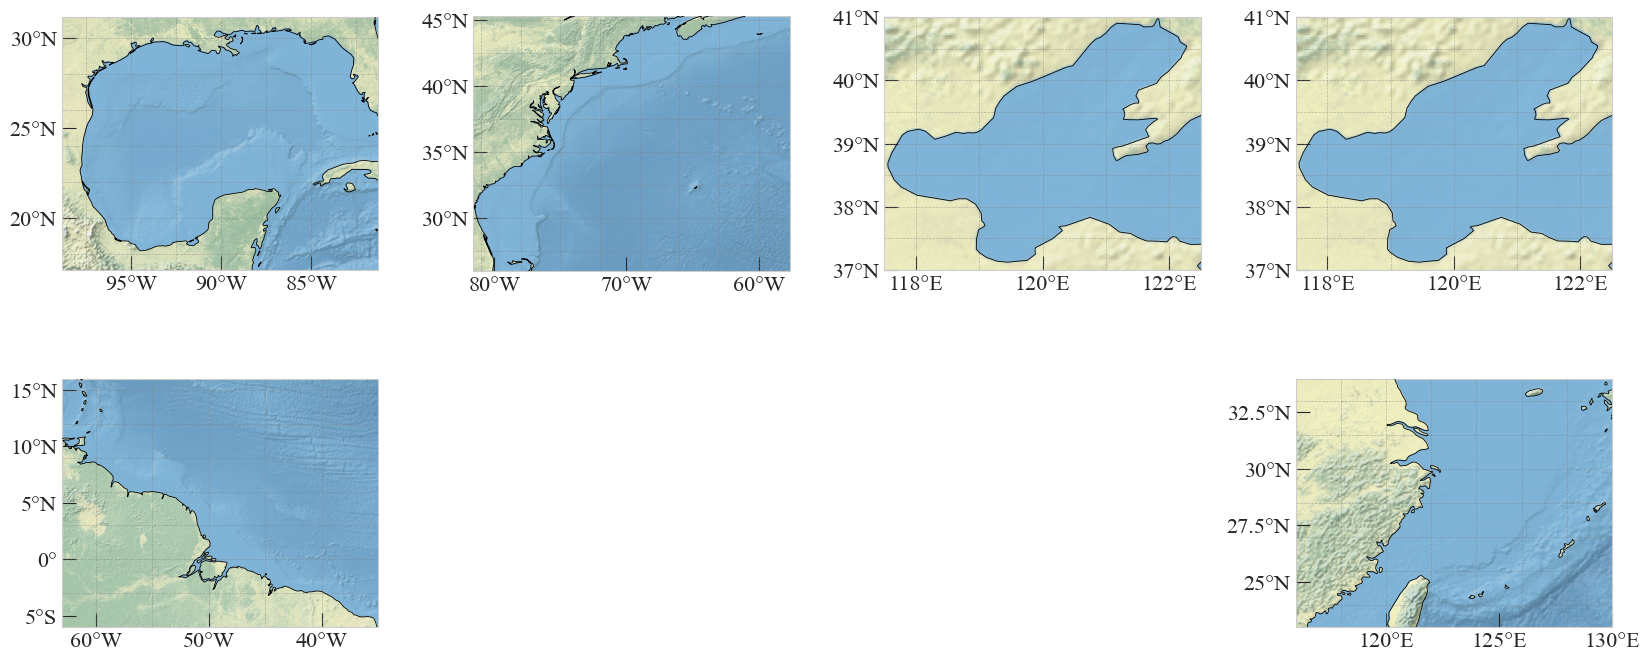

In [4]:
import cartopy.crs as ccrs
import cartopy.feature as cfeat
import matplotlib.pyplot as plt
from matplotlib.image import imread
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter

# 定义六个地区空间范围的列表，每个列表元素包含四个参数：西经、东经、南纬、北纬
regions = [[-98.86, -81.28, 17.09, 31.16],
           [-81.6, -57.66, 26, 45.3],
           [117.5, 122.5, 37, 41],
           [117.5, 122.5, 37, 41],
           [-63, -35, -6, 16],
           [-180, 180, -90, 90],
           [120, 180, 0, 60],
           [116, 130, 23, 34]]

# 创建地图投影
proj = ccrs.PlateCarree()

# 创建地图边界范围
extent = [-180, 180, -90, 90]

# 创建地图子图
fig, axs = plt.subplots(nrows=2, ncols=4, subplot_kw={'projection': proj},
                        figsize=(20, 8), gridspec_kw={'hspace': 0.4, 'wspace': 0.3})

for i, ax in enumerate(axs.flat):
    if i == 5:
        fig.delaxes(axs[1, 1])
        fig.delaxes(axs[1, 2])

    else:
        # 添加地图特征，包括海岸线、边界、州界等
        # --加载省界线
        # --加载分辨率为50的海岸线
        ax.add_feature(cfeat.COASTLINE.with_scale('50m'), linewidth=0.6, zorder=10)
        ax.set_extent([105, 133, 15, 45])  # 可根据需求自行定义
        # ax.stock_img()  ##可直接使用低分辨率背景
        # --加载高分辨率地形
        ax.imshow(
            imread('./0_cartopy_data/NE1_50M_SR_W.tif'),
            origin='upper', transform=proj,
            extent=[-180, 180, -90, 90]
        )
        ax.set_extent(regions[i], crs=proj)

        # 添加经纬度网格线
        ax.gridlines(draw_labels=False, linewidth=0.5, color='gray', alpha=0.5, linestyle='--')
        ax.set_frame_on(True)
        ax.patch.set_visible(False)
        ax.xaxis.set_visible(True)
        ax.yaxis.set_visible(True)

        # 设置坐标轴刻度样式，只在左侧和下侧显示刻度
        ax.tick_params(axis='both', which='major', labelsize=16, direction='in', length=10, bottom=True, left=True)
        ax.tick_params(axis='both', which='minor', width=0)
        labels = ax.get_xticklabels()+ ax.get_yticklabels()
        [label.set_fontname('Times New Roman') for label in labels]
        ax.xaxis.set_major_formatter(LongitudeFormatter())
        ax.yaxis.set_major_formatter(LatitudeFormatter())

plt.savefig('./Essay_illustration/research_areas.png',dpi=300,bbox_inches='tight')
plt.show()


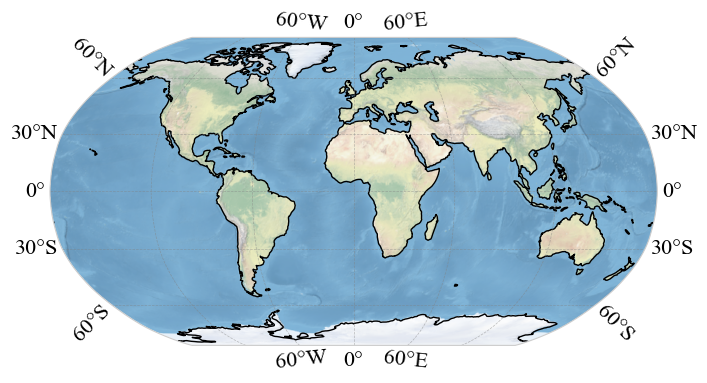

In [12]:
import cartopy.crs as ccrs
import cartopy.feature as cfeat
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(10, 4))
ax2 = fig.add_subplot(1, 1, 1, projection=ccrs.Robinson())

# 设置地图边界范围
ax2.set_global()

# 添加地图特征
ax2.stock_img()
ax2.coastlines()
# 添加经纬度网格线和标签
gl=ax2.gridlines(draw_labels=True, linewidth=0.5, color='gray', alpha=0.5, linestyle='--')
gl.xlabel_style = {'size': 16, 'color': 'black','family' : 'Times New Roman'}
gl.ylabel_style = {'size': 16, 'color': 'black','family' : 'Times New Roman'}
plt.show()